# Content of the notebook

This notebook contains all steps to create the additional test set, downloaded from Sabio-RK, to vaildate the KM prediction model used in the paper "Prediction of Michaelis constants $K_M$ from structural features".

The location of the folder with all datasets must be changed (to the corresponding path on your PC) in the python file "directory_infomation.py" before executing this notebook.

## The notebook consists of the following steps:

1. Downloading data from Sabio-RK and removing all data points that are in the BRENDA database
2. Mapping substrate names to KEGG Compound IDs
3. Downloading amino acid sequences for all enzymes:
4. Calculating UniRep vectors for the amino acid sequences of the enzymes
5. Adding GNN fingerprints, MW, and LogP for the substrates
6. Making predictions for all data points

Loading all the necessary packages and functions to execute the code:

In [1]:
import requests
import pandas as pd
import numpy as np
import sys
import os
from os.path import join
import math
import time
import logging
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import xgboost as xgb
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors

logfile = "datacount_sabio.log"


from directory_infomation import *

from build_GNN import *
from functions_and_dicts_data_preprocessing_GNN import *
from functions_for_data_preprocessing import *
#from functions_for_unirep_calculations import *

## 1. Download data from Sabio-RK and removing all data points that are in the BRENDA database:

In [5]:
wsdl = "https://www.brenda-enzymes.org/soap/brenda_zeep.wsdl"
password = hashlib.sha256("a2b8c6".encode("utf-8")).hexdigest()
email = "alexander.kroll@hhu.de"
client = Client(wsdl)

df = download_sabio_data()
df.to_csv(join(datasets_dir, "Sabio_data", "Sabio_raw_data.csv"))

67858 matching entries found.
Downloading...
Download finished! 44647


In [6]:
df = pd.read_csv(join(datasets_dir, "Sabio_data", "Sabio_raw_data.csv"))

df = preprocess_raw_sabio_DataFrame(df)

Check for all PubMedIDs in the Sabio dataset if they occur in the BRENDA dataset. If yes, we remove these data points:

In [7]:
Sabio_PMIDs = list(set(df["PubMedID"]))
PMIDs_in_BRENDA = get_PMIDs_that_are_in_BRENDA(Sabio_PMIDs, df)

droplist = []

for ind in df.index:
    if df["PubMedID"][ind] in PMIDs_in_BRENDA:
        droplist.append(ind)
        
df.drop(droplist, inplace = True)
sabio_df = df
sabio_df

,Organism,ECNumber,KM,PubMedID,substrate,UniprotID,log10_KM
245,Serratia marcescens,3.2.1.14,5.900000e-05,15178342.0,Chitobiose,P07254 P11797,-1.229148
251,Serratia marcescens,3.2.1.14,6.000000e-04,15178342.0,Chitobiose,P07254 P11797,-0.221849
254,Serratia marcescens,3.2.1.14,6.300000e-05,15178342.0,Chitobiose,P07254 P11797,-1.200659
469,Rattus norvegicus,3.1.3.11,1.000000e-05,8396135.0,"D-Fructose 1,6-bisphosphate",Q9Z1N1 P19112,-2.000000
495,Sus scrofa,1.1.1.42,3.300000e-07,15005617.0,Mn2+,P33198,-3.481486
...,...,...,...,...,...,...,...
43442,Enterococcus faecalis,2.7.1.30,9.000000e-04,3011747.0,Glycerol,O34154,-0.045757
44468,Homo sapiens,5.1.3.2,1.400000e-04,11841944.0,UDPgalactose,Q14376,-0.853872
44469,Escherichia coli,1.1.1.22,2.000000e-05,11841944.0,UDPglucose,P76373,-1.698970
44473,Streptococcus thermophilus,5.1.3.2,1.000000e-04,11841944.0,UDPgalactose,P21977,-1.000000


## 2. Mapping substrate names to KEGG Compound IDs

### (a) Mapping substrate names from BRENDA to KEGG Compound IDs (CIDs)

In [8]:
drugs_df = pd.read_pickle(join(datasets_dir, "substrate_synonyms", "KEGG_drugs_df.pkl"))
compounds_df = pd.read_pickle(join(datasets_dir, "substrate_synonyms", "KEGG_substrate_df.pkl"))
KEGG_substrate_df = compounds_df.append(drugs_df).reset_index(drop = True)

##If we have multiple IDs for the same substrate name, we keep the first ID:
droplist = []
for ind in KEGG_substrate_df.index:
    if not ind in droplist:
        substrate = KEGG_substrate_df["substrate"][ind]
        help_df = KEGG_substrate_df.loc[KEGG_substrate_df["substrate"] == substrate]
        if len(help_df) > 1 :
            droplist = droplist + list(help_df.index)[1:]

KEGG_substrate_df.drop(droplist, inplace = True)
KEGG_substrate_df.head()

,KEGG ID,substrate
0,C00001,H2O
1,C00001,Water
2,C00002,ATP
3,C00002,Adenosine 5'-triphosphate
4,C00003,NAD+


Converting all substrate names in KEGG_substrate_df and sabio_df to substrate names that only contain lower case letters:

In [9]:
KEGG_substrate_df["substrate"] = [name.lower() for name in KEGG_substrate_df["substrate"]]
sabio_df["substrate"] = [name.lower() for name in sabio_df["substrate"]]

Mapping substrate names from brenda_df to KEGG CIDs:

In [10]:
sabio_df = sabio_df.merge(KEGG_substrate_df, on = "substrate", how = "left")
print("For %s out of %s data points we could not map the substrate name to a KEGG ID." %
      (sum(pd.isnull(sabio_df["KEGG ID"])), len(sabio_df)))

For 12 out of 689 data points we could not map the substrate name to a KEGG ID.


###  (b) For all the substrate names that could not be mapped to KEGG CIDs yet: We try to map them with a synonym list from PubChem to PubChem CIDs first and then to KEGG CIDs

In [11]:
#creating a list with all substrate names that couldn't be mapped to KEGG IDs
unmapped_substrates = list(set(list(sabio_df["substrate"][pd.isnull(list(sabio_df["KEGG ID"]))])))
matches = substrate_names_to_Pubchem_CIDs(unmapped_substrates)

loading part 1 of 5 of the synonym list...
searching in synoynm list part 1 for matches
loading part 2 of 5 of the synonym list...
searching in synoynm list part 2 for matches
loading part 3 of 5 of the synonym list...
searching in synoynm list part 3 for matches
loading part 4 of 5 of the synonym list...
searching in synoynm list part 4 for matches
loading part 5 of 5 of the synonym list...
searching in synoynm list part 5 for matches


In [12]:
matches.to_pickle(join(datasets_dir, "substrate_synonyms", "Pubchem_substrate_matches_sabio.pkl"))

Mapping all PubChem CIDs to KEGG CIDs: Therefore, we create a txt-file ("Pubchem_CIDs_sabio.txt") that contains all PubChem CIDs that we want to map to KEGG CIDs:

In [13]:
matches = pd.read_pickle(join(datasets_dir, "substrate_synonyms", "Pubchem_substrate_matches_sabio.pkl"))

#convert CIDs from strings to integers:
for ind in matches.index:
    cid = matches.loc[ind]["CID"]
    if not pd.isnull(cid):
        matches["CID"][ind] = int(cid)
        
        
#create txt file with all CIDs in matches:
CIDs = list(matches.loc[~ pd.isnull(matches["CID"])]["CID"])
f = open(join(datasets_dir, "substrate_synonyms", "Pubchem_CIDs_sabio.txt"),"w") 
for cid in CIDs:
    f.write(str(cid) + "\n")
f.close()

The txt-file "Pubchem_CIDs.txt" can be used as the input for the webservice http://csbg.cnb.csic.es/mbrole2/conversion.php to map the Pubchem CIDs to KEGG CIDs. The resulting file "mbrole_conversion.tsv" should be stored in the directory for substrate synonyms.

In [14]:
#load the resulting file and store it in a DataFrame:
Pubchem_CID_to_KEGG_df = pd.read_csv(join(datasets_dir, "substrate_synonyms", "mbrole2_conversion_sabio.tsv"), sep= "\t")
#rename columns:
Pubchem_CID_to_KEGG_df.rename(columns = {"Input" : "CID", "Output" : "KEGG ID"}, inplace = True)

#merge this DataFrame with the DataFrame called matches:
macthes_with_KEGG_IDs = pd.merge(matches, Pubchem_CID_to_KEGG_df, how='left', on=['CID'])
macthes_with_KEGG_IDs.drop(columns = ["Input_source", "Output_source"], inplace = True)
macthes_with_KEGG_IDs.rename(columns = {"Metabolite" : "substrate"}, inplace = True)

macthes_with_KEGG_IDs.head()

,substrate,CID,KEGG ID
0,delta(l-2-aminoadipyl)-l-cysteinyl-d-valine,448130,NaN
1,glycerate 2-phosphate,59,NaN
2,"9,10-epoxystearic acid",15868,C19418
3,cd2+,31193,NaN
4,"2,3-dimethoxy-5-methyl-1,4-benzoquinone",69068,NaN


Mapping all newly found KEGG CIDs to substrate names in the Brenda DataFrame:

In [15]:
for ind in sabio_df.index:
    if pd.isnull(sabio_df["KEGG ID"][ind]):
        substrate = sabio_df["substrate"][ind]
        try:
            KEGG_ID = list(macthes_with_KEGG_IDs.loc[macthes_with_KEGG_IDs["substrate"]== substrate]["KEGG ID"])[0]
            sabio_df["KEGG ID"][ind] = KEGG_ID
        except:
            None

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
sabio_df = sabio_df.loc[~pd.isnull(sabio_df["KEGG ID"])]
#remove KM values for ions:
sabio_df = sabio_df.loc[sabio_df["KEGG ID"] != "C19610"]
sabio_df = sabio_df.loc[sabio_df["KEGG ID"] != "C00305"]
sabio_df = sabio_df.loc[sabio_df["KEGG ID"] != "C00038"]

Take the geometric mean over all KM values if they have the same KEGG and Uniprot ID:

In [17]:
sabio_df = sabio_df.drop(columns = ["PubMedID", "ECNumber", "substrate", "KM"])
sabio_df = sabio_df.groupby(["Organism", "UniprotID", "KEGG ID"], as_index = False).mean()
sabio_df
sabio_df.to_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint1_V2.pkl"))

## 3. Downloading amino acid sequences for all enzymes:

### (a) If we have a Uniprot ID for the enzyme, we use the UniProt mapping service to get the amino acid sequence

Creating a text file with all all Uniprot IDs in our DataFrame:

In [18]:
#sabio_df = pd.read_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint1_V2.pkl"))
IDs = []
for ind in sabio_df.index:
    IDs = IDs + [sabio_df["UniprotID"][ind]]
    
f = open(join(datasets_dir, "enzyme_data", "UNIPROT_IDs_sabio.txt"),"w") 
for ID in list(set(IDs)):
    f.write(str(ID) + "\n")
f.close()

We map the Uniprot IDs to amino acid sequences via the UniProt mapping service (https://www.uniprot.org/uploadlists/). The result is stored in a csv-file:

In [19]:
sabio_df["Sequence"] = ""

UNIPROT_df = pd.read_csv(join(datasets_dir, "enzyme_data", "UNIPROT_results_sabio.csv"), sep = ";")

for ind in sabio_df.index:
    ID = sabio_df["UniprotID"][ind]
    try:
        sabio_df["Sequence"][ind] = list((UNIPROT_df["Sequence"].loc[UNIPROT_df["UNIPROT ID"] == ID]))[0]
    except: pass

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
sabio_df = sabio_df.loc[sabio_df["Sequence"] != ""]
sabio_df

,Organism,UniprotID,KEGG ID,log10_KM,Sequence
0,Acetobacter pasteurianus,Q8L388,C00022,0.149317,MTYTVGMYLAERLVQIGLKHHFAVGGDYNLVLLDQLLLNKDMKQIY...
1,Aeropyrum pernix,Q9YA47,C00002,-0.376751,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...
2,Aeropyrum pernix,Q9YA47,C00031,-1.356547,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...
3,Aeropyrum pernix,Q9YA47,C00095,-0.823909,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...
4,Aeropyrum pernix,Q9YA47,C00159,-0.958607,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...
...,...,...,...,...,...
352,Xenopus laevis,P08734,C00631,-1.221849,MSIKNIRAREIFDSRGNPTVEVDLYTCKGLFRAAVPSGASTGIYEA...
353,Xenopus laevis,P30759,C00062,1.542824,MAKERHSVGVIGAPFSKGQPRRGVEEGPKYLREAGLIEKLREFGND...
354,Yersinia enterocolitica,P15273,C03360,0.414973,MNLSLSDLHRQVSRLVQQESGDCTGKLRGNVAANKETTFQGLTIAS...
355,Zymobacter palmae,Q8KTX6,C00022,-0.384265,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...


In [21]:
sabio_df.reset_index(inplace = True, drop = True)
sabio_df.to_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint2_V2.pkl"))

In [22]:
#sabio_df.to_csv(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint2.csv"))
#sabio_df = pd.read_csv(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint2.csv"))

In [23]:
sabio_df = pd.read_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint2_V2.pkl"))

## 4. Calculating UniRep vectors for the amino acid sequences of the enzymes

To calculate the UniRep vectors, we use code that is copied from Martin Enqvist's github repository (https://github.com/EngqvistLab/UniRep50). Enqvist's code relies on the UniRep representation created by George Church's group (https://github.com/churchlab/UniRep)

To calculate the UniRep vectors, we need to store all sequences in a FASTA-file:

In [24]:
ofile = open(join(datasets_dir, "enzyme_data", "all_sequences_sabio.fasta"), "w")
for ind in sabio_df.index:
    seq = sabio_df["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        ofile.write(">" + str(ind) + "\n" +seq[:seq_end] + "\n")
ofile.close()

#### <span style="color:red">Attetntion: Calculating the UniRep vectors requires tensorflow version 1.15.0 (in compariosn to the Graph Neural Network, for which tensorflow 2 is required). Also calculating the UniRep vectors takes a lot of time if tensorflow is not running on GPU.</span>

In [25]:
X_unirep = compute_unirep_representations(fasta_file = join(datasets_dir, "enzyme_data", "all_sequences_sabio.fasta"),
                                          rep_file = join(datasets_dir, "enzyme_data", "unirep_representations_sabio.tsv"))

In [26]:
Unirep_df = pd.read_csv(join(datasets_dir, "enzyme_data", "unirep_representations_sabio.tsv"), sep = "\t")
sabio_df = add_Unirep_vector(sabio_df, Unirep_df)
sabio_df.head()

.\additional_code\functions_for_data_preprocessing.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Unirep"][ind] = X_Unirep[i,1:]
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Organism,UniprotID,KEGG ID,log10_KM,Sequence,Unirep
0,Acetobacter pasteurianus,Q8L388,C00022,0.149317,MTYTVGMYLAERLVQIGLKHHFAVGGDYNLVLLDQLLLNKDMKQIY...,"[0.009362391999999999, 0.1846365, 0.16759616, ..."
1,Aeropyrum pernix,Q9YA47,C00002,-0.376751,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232..."
2,Aeropyrum pernix,Q9YA47,C00031,-1.356547,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232..."
3,Aeropyrum pernix,Q9YA47,C00095,-0.823909,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232..."
4,Aeropyrum pernix,Q9YA47,C00159,-0.958607,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232..."


## 5. Adding GNN fingerprints, MW, and LogP for the substrates

### (a) Add MW and LogP for substrate to DataFrame

In [27]:
sabio_df["MW"] = np.nan
sabio_df["LogP"] = np.nan

for ind in sabio_df.index:
    kegg_id = sabio_df["KEGG ID"][ind]
    try:
        mol = Chem.MolFromMolFile(datasets_dir +  "/mol-files/" + kegg_id + '.mol')
    except OSError:
        None
    if mol is not None:
        sabio_df["MW"][ind] = Descriptors.ExactMolWt(mol)
        sabio_df["LogP"][ind] = Crippen.MolLogP(mol)

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [28]:
droplist = []
for ind in sabio_df.index:
    droplist.append(calculate_and_save_input_matrixes(sample_ID = "sabio_" + str(ind), 
                                                      molecule_ID = sabio_df["KEGG ID"][ind],
                                                      unirep = sabio_df["Unirep"][ind], 
                                                      extras = np.array([sabio_df["MW"][ind], sabio_df["LogP"][ind]]),
                                                      save_folder = join(datasets_dir, "GNN_input_data")))

Could not create input for substrate ID C01794


In [29]:
droplist = list(np.array(droplist)[np.array(droplist) != -1])
sabio_df.drop(droplist, inplace = True)

In [30]:
sabio_df.to_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint3_V2.pkl"))

In [31]:
sabio_df = pd.read_pickle(join(datasets_dir, "Sabio_data", "sabio_df_checkpoint3_V2.pkl"))

In [32]:
sabio_df

,Organism,UniprotID,KEGG ID,log10_KM,Sequence,Unirep,MW,LogP
0,Acetobacter pasteurianus,Q8L388,C00022,0.149317,MTYTVGMYLAERLVQIGLKHHFAVGGDYNLVLLDQLLLNKDMKQIY...,"[0.009362391999999999, 0.1846365, 0.16759616, ...",88.016044,-0.34000
1,Aeropyrum pernix,Q9YA47,C00002,-0.376751,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232...",506.995745,-1.62900
2,Aeropyrum pernix,Q9YA47,C00031,-1.356547,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232...",180.063388,-3.22140
3,Aeropyrum pernix,Q9YA47,C00095,-0.823909,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232...",180.063388,-3.21980
4,Aeropyrum pernix,Q9YA47,C00159,-0.958607,MAEVVAVDVGATWVRMAIVRGGVIEAIKRERNPGTEEGLERVLQGL...,"[0.022074042000000002, -0.022069417, 0.0664232...",180.063388,-3.22140
...,...,...,...,...,...,...,...,...
270,Xenopus laevis,P08734,C00631,-1.221849,MSIKNIRAREIFDSRGNPTVEVDLYTCKGLFRAAVPSGASTGIYEA...,"[0.0051546856, 0.12054449, 0.13123453, -0.0241...",185.992939,-1.45880
271,Xenopus laevis,P30759,C00062,1.542824,MAKERHSVGVIGAPFSKGQPRRGVEEGPKYLREAGLIEKLREFGND...,"[0.006347216, 0.12308962, 0.18849312, -0.03078...",174.111676,-1.33843
272,Yersinia enterocolitica,P15273,C03360,0.414973,MNLSLSDLHRQVSRLVQQESGDCTGKLRGNVAANKETTFQGLTIAS...,"[0.0031505841999999997, -0.02765534, 0.0514622...",218.993274,1.06630
273,Zymobacter palmae,Q8KTX6,C00022,-0.384265,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...,"[0.007651806, 0.19671498, 0.11644461, -0.01789...",88.016044,-0.34000


### (b) Calculating GNN Fingerprints

In [33]:
batch_size = 64
D = 50
learning_rate = 0.05
epochs = 50
l2_reg_fc = 1
l2_reg_conv = 0.01
rho = 0.95


model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)
model.load_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,  model.layers[3].input, model.layers[36].input],
                                  [model.layers[-10].output])

In [34]:
def get_substrate_representations(df, prefix):
    df["GNN FP"] = ""
    i = 0
    n = len(df)
    UniRep = np.zeros((64, 20))
    
    cid_all = list(df.index)
    cid_all = [prefix + str(cid) for cid in cid_all]
    
    while i*64 <= n:
        if (i+1)*64  <= n:
            XE, X, A, extras = get_representation_input(cid_all[i*64:(i+1)*64])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A),
                                                   np.array(extras)])[0]
            df["GNN FP"][i*64:(i+1)*64] = list(representations[:, :52])
        else:
            print(i)
            XE, X, A, extras = get_representation_input(cid_all[-64:])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A), 
                                                   np.array(extras)])[0]
            df["GNN FP"][-64:] = list(representations[:, :52])
        i += 1
        
    ### set all GNN FP-entries with no input matrices to np.nan:
    all_X_matrices = os.listdir(input_data_folder)
    for ind in df.index:
        if prefix +str(ind) +"_X.npy" not in all_X_matrices:
            df["GNN FP"][ind] = np.nan
    return(df)

In [35]:
sabio_df = get_substrate_representations(df = sabio_df, prefix = "sabio_")

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


4


C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 6. Making predictions for all data points

In [36]:
bst = pickle.load(open(join(datasets_dir, "model_weights", "xgboost_model.dat"), "rb"))

In [37]:
fingerprints = np.array(list(sabio_df["GNN FP"]))
UniRep = np.array(list(sabio_df["Unirep"]))

X = np.concatenate([fingerprints, UniRep[:,:1900]], axis = 1)
Y = np.array(list(sabio_df["log10_KM"]))
dsabio = xgb.DMatrix(X, label = Y)

In [38]:
pred_sabio = bst.predict(dsabio)
GB_enzyme_sub_test_MSE = np.mean(abs(pred_sabio - np.reshape(Y, (-1)))**2)
GB_enzyme_sub_test_R2 = r2_score(np.reshape(Y, (-1,1)), pred_sabio)

In [39]:
np.save(join(datasets_dir, "training_results", "XGB_Sabio_MSE.npy"), GB_enzyme_sub_test_MSE)
np.save(join(datasets_dir, "training_results", "XGB_Sabio_R.npy"), GB_enzyme_sub_test_R2)
GB_enzyme_sub_test_MSE, GB_enzyme_sub_test_R2

(0.6651280406444395, 0.5009155548560822)

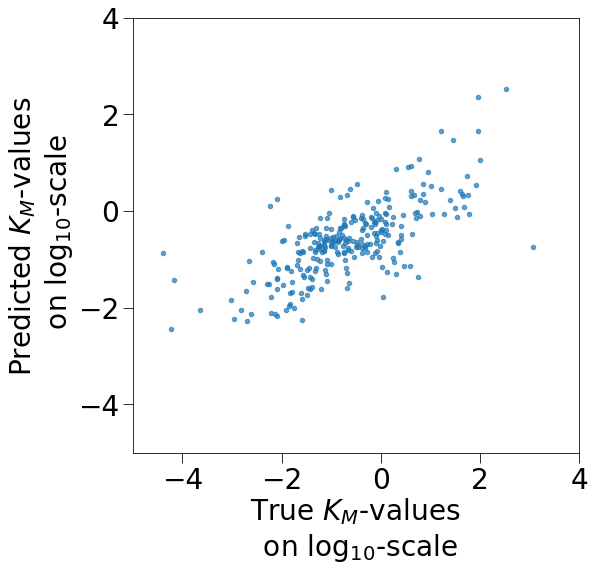

In [40]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})


plt.ylim(ymax = 4, ymin = -5)
plt.xlim(xmax = 4, xmin = -5)

ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)

plt.ylabel("Predicted $K_M$-values \n on $\log_{10}$-scale")
plt.xlabel("True $K_M$-values \n on $\log_{10}$-scale")
plt.scatter(Y, pred_sabio, alpha = 0.7, s=20)
plt.show()